## Build a regression model to predict property crimes, the focus is on creating a model that explains a lot of variance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn import linear_model
%matplotlib inline
plt.style.use("seaborn")

In [2]:
crime_data = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls",skiprows=4)
crime_data.head(5)
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    #print(crime_data[["City","Population","Property\ncrime"]])

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


In [3]:
# display column headers for possible rename simplification
print(crime_data.columns.values.tolist())

['City', 'Population', 'Violent\ncrime', 'Murder and\nnonnegligent\nmanslaughter', 'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2', 'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3']


In [4]:
# rename murder and property crime column
crime_data = crime_data.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder","Property\ncrime":"Property Crime"})

In [5]:
# create population squared feature for prediction 
crime_data["Population^2"] = crime_data["Population"].apply(lambda x: x**2)

In [6]:
# found that New York Total was present in data set, need to drop
crime_data = crime_data[crime_data["City"] != "New York"]
crime_data.describe()

,Population,Violent crime,Murder,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property Crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population^2
count,347.000000,347.000000,347.000000,0.0,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,187.000000,3.470000e+02
mean,15956.685879,51.213256,0.605187,NaN,2.677233,17.867435,30.063401,385.752161,72.172911,298.994236,14.585014,1.871658,9.858407e+08
std,27080.218837,236.667435,3.707090,NaN,10.741020,94.972492,128.783376,1034.369072,264.941381,715.232296,67.682236,10.693411,5.067232e+09
min,526.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.766760e+05
25%,2997.000000,2.000000,0.000000,NaN,0.000000,0.000000,1.000000,40.000000,6.000000,31.000000,0.000000,0.000000,8.982153e+06
50%,7187.000000,6.000000,0.000000,NaN,0.000000,1.000000,4.000000,112.000000,17.000000,94.000000,2.000000,0.000000,5.165297e+07
75%,18160.500000,21.500000,0.000000,NaN,2.000000,5.000000,14.000000,340.500000,51.000000,284.500000,7.000000,1.000000,3.298042e+08
max,258789.000000,3249.000000,47.000000,NaN,145.000000,1322.000000,1735.000000,12491.000000,3458.000000,8076.000000,957.000000,132.000000,6.697175e+10


## Function Specification for Model:

### PropertyCrime = x + Population + Population^2 + Murder + Robbery

In [7]:
crime_model = crime_data[["Population","Murder","Robbery","Property Crime","Population^2"]]
crime_model.head(5)

,Population,Murder,Robbery,Property Crime,Population^2
0,1861.0,0.0,0.0,12.0,3.463321e+06
1,2577.0,0.0,0.0,24.0,6.640929e+06
2,2846.0,0.0,0.0,16.0,8.099716e+06
3,97956.0,8.0,227.0,4090.0,9.595378e+09
4,6388.0,0.0,4.0,223.0,4.080654e+07


In [8]:
# check for NaN values
crime_model.isnull().sum()

Population        3
Murder            3
Robbery           3
Property Crime    3
Population^2      3
dtype: int64

In [9]:
# check which rows contain NaN values (determine scope of missing values)
for col in crime_model.columns:
    print(crime_model[crime_model[col].isnull()][crime_model.columns[crime_model.isnull().any()]])

     Population  Murder  Robbery  Property Crime  Population^2
348         NaN     NaN      NaN             NaN           NaN
349         NaN     NaN      NaN             NaN           NaN
350         NaN     NaN      NaN             NaN           NaN
     Population  Murder  Robbery  Property Crime  Population^2
348         NaN     NaN      NaN             NaN           NaN
349         NaN     NaN      NaN             NaN           NaN
350         NaN     NaN      NaN             NaN           NaN
     Population  Murder  Robbery  Property Crime  Population^2
348         NaN     NaN      NaN             NaN           NaN
349         NaN     NaN      NaN             NaN           NaN
350         NaN     NaN      NaN             NaN           NaN
     Population  Murder  Robbery  Property Crime  Population^2
348         NaN     NaN      NaN             NaN           NaN
349         NaN     NaN      NaN             NaN           NaN
350         NaN     NaN      NaN             NaN       

In [10]:
# rows appear to be consistent across columns, can remove all rows with NaN
crime_model = crime_model.dropna(how="all")
crime_model.isnull().sum()

Population        0
Murder            0
Robbery           0
Property Crime    0
Population^2      0
dtype: int64

In [11]:
# correlation coefficient between columns
crime_model.corr()

,Population,Murder,Robbery,Property Crime,Population^2
Population,1.000000,0.756401,0.815525,0.887255,0.888582
Murder,0.756401,1.000000,0.963290,0.917135,0.883650
Robbery,0.815525,0.963290,1.000000,0.932889,0.939956
Property Crime,0.887255,0.917135,0.932889,1.000000,0.893456
Population^2,0.888582,0.883650,0.939956,0.893456,1.000000


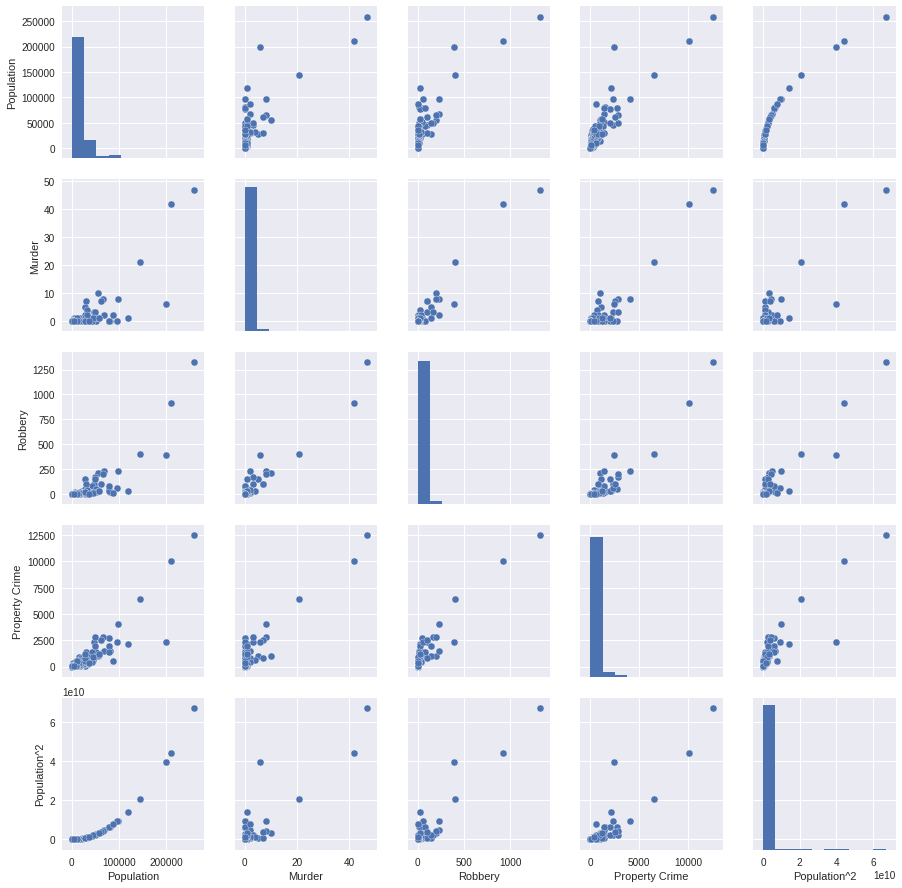

In [12]:
# visualize data to find possible outliers and distribution of data
sns.pairplot(crime_model)
plt.show()

In [13]:
# check dtypes of columns to check for compatibility
crime_model.dtypes

Population        float64
Murder            float64
Robbery           float64
Property Crime    float64
Population^2      float64
dtype: object

In [14]:
# describe dataset
crime_model.describe()

,Population,Murder,Robbery,Property Crime,Population^2
count,347.000000,347.000000,347.000000,347.000000,3.470000e+02
mean,15956.685879,0.605187,17.867435,385.752161,9.858407e+08
std,27080.218837,3.707090,94.972492,1034.369072,5.067232e+09
min,526.000000,0.000000,0.000000,0.000000,2.766760e+05
25%,2997.000000,0.000000,0.000000,40.000000,8.982153e+06
50%,7187.000000,0.000000,1.000000,112.000000,5.165297e+07
75%,18160.500000,0.000000,5.000000,340.500000,3.298042e+08
max,258789.000000,47.000000,1322.000000,12491.000000,6.697175e+10


In [15]:
# normalize data to adjust visuals
def normalize_data(df):
    x = (df-df.min())/(df.max()-df.min())
    return x

col_list = crime_model.columns.values.tolist()

for col in col_list:
    crime_model[col] = normalize_data(crime_model[col])
    # change 0 values for transformations
    crime_model[col] = crime_model[col].mask(crime_model[col] == 0, 0.00001)
    
crime_model.describe()   

,Population,Murder,Robbery,Property Crime,Population^2
count,347.000000,347.000000,347.000000,347.000000,347.000000
mean,0.059748,0.012885,0.013519,0.030883,0.014716
std,0.104855,0.078873,0.071839,0.082809,0.075663
min,0.000010,0.000010,0.000010,0.000010,0.000002
25%,0.009568,0.000010,0.000010,0.003202,0.000130
50%,0.025792,0.000010,0.000756,0.008966,0.000767
75%,0.068281,0.000010,0.003782,0.027260,0.004920
max,1.000000,1.000000,1.000000,1.000000,1.000000


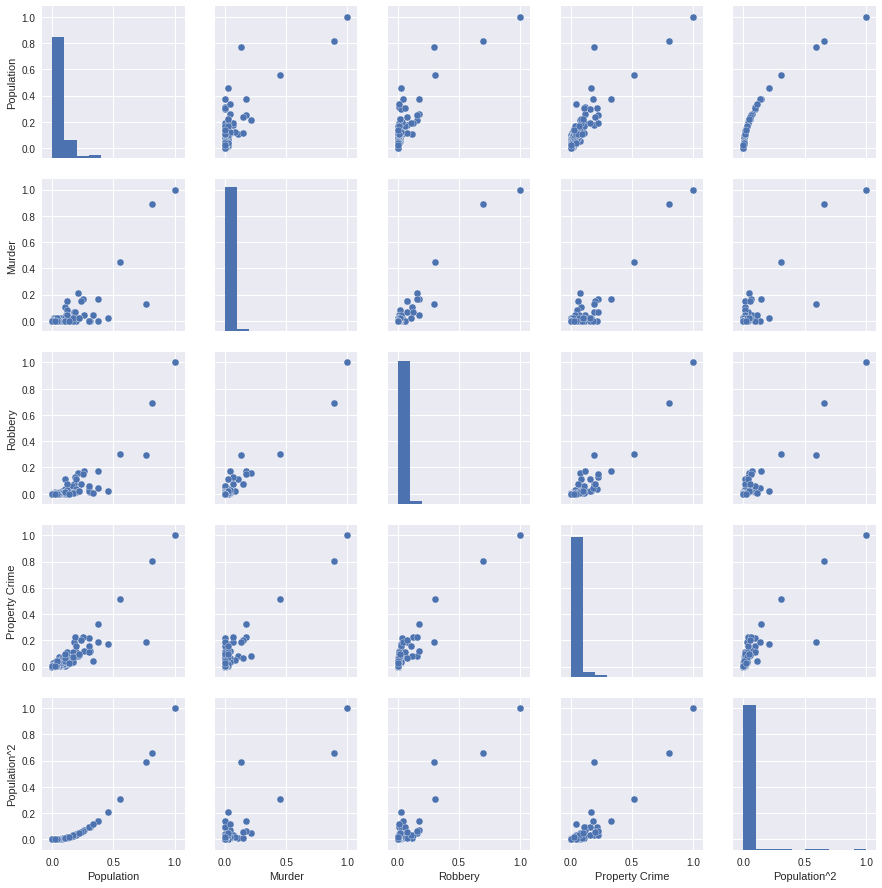

In [16]:
sns.pairplot(crime_model)
plt.show()

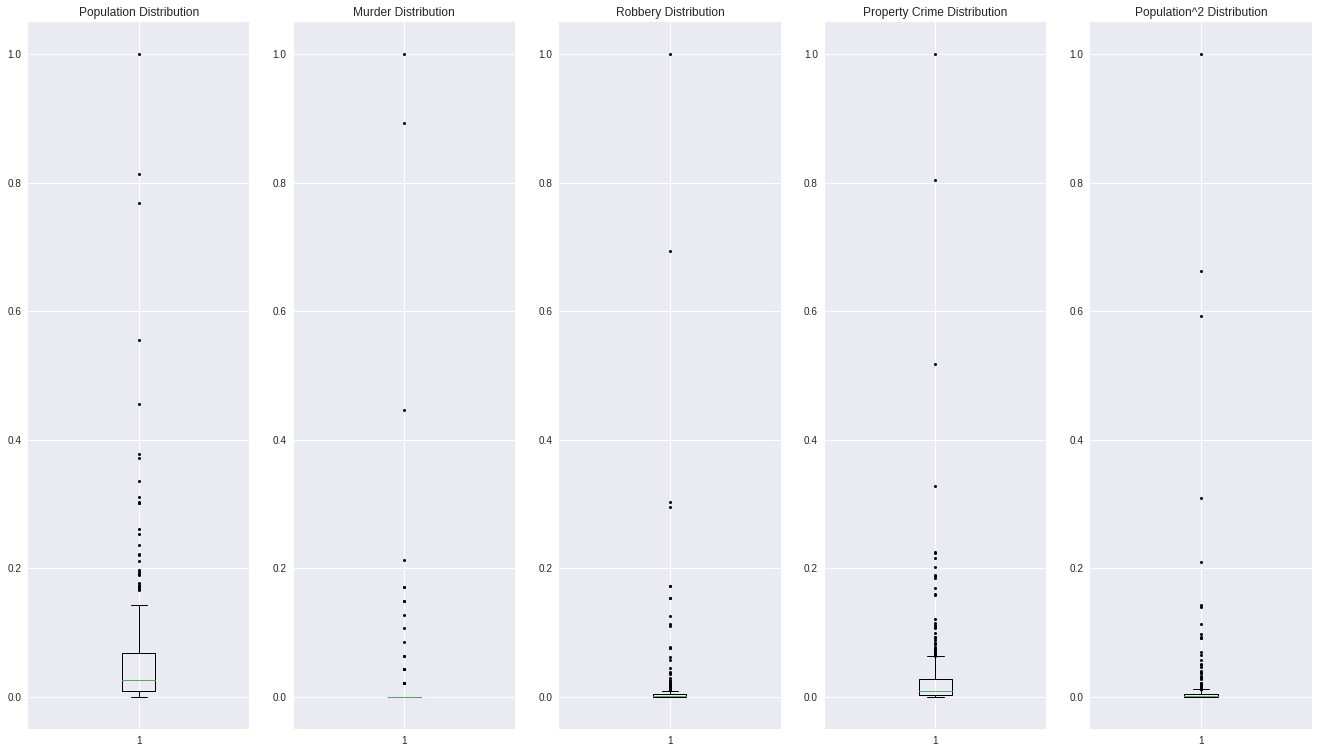

In [17]:
# appears to be some outliers, use boxplot to get clearer visual
plt.rcParams['figure.figsize'] = (23,13)
fig,ax = plt.subplots(ncols = 5)
y = 0
for col in col_list:
    ax[y].boxplot(crime_model[col],sym="k.")
    ax[y].set_title(col + " Distribution")
    y+=1
plt.show()

In [18]:
# describe dataset to locate potential outlier
crime_model.describe()

,Population,Murder,Robbery,Property Crime,Population^2
count,347.000000,347.000000,347.000000,347.000000,347.000000
mean,0.059748,0.012885,0.013519,0.030883,0.014716
std,0.104855,0.078873,0.071839,0.082809,0.075663
min,0.000010,0.000010,0.000010,0.000010,0.000002
25%,0.009568,0.000010,0.000010,0.003202,0.000130
50%,0.025792,0.000010,0.000756,0.008966,0.000767
75%,0.068281,0.000010,0.003782,0.027260,0.004920
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# appears to be some significant outliers in data, proceed to clean
from scipy import stats
def transform_df(df_col):
    x,lam = stats.boxcox(df_col)
    return x

for col in col_list:
    crime_model[col] = transform_df(crime_model[col])

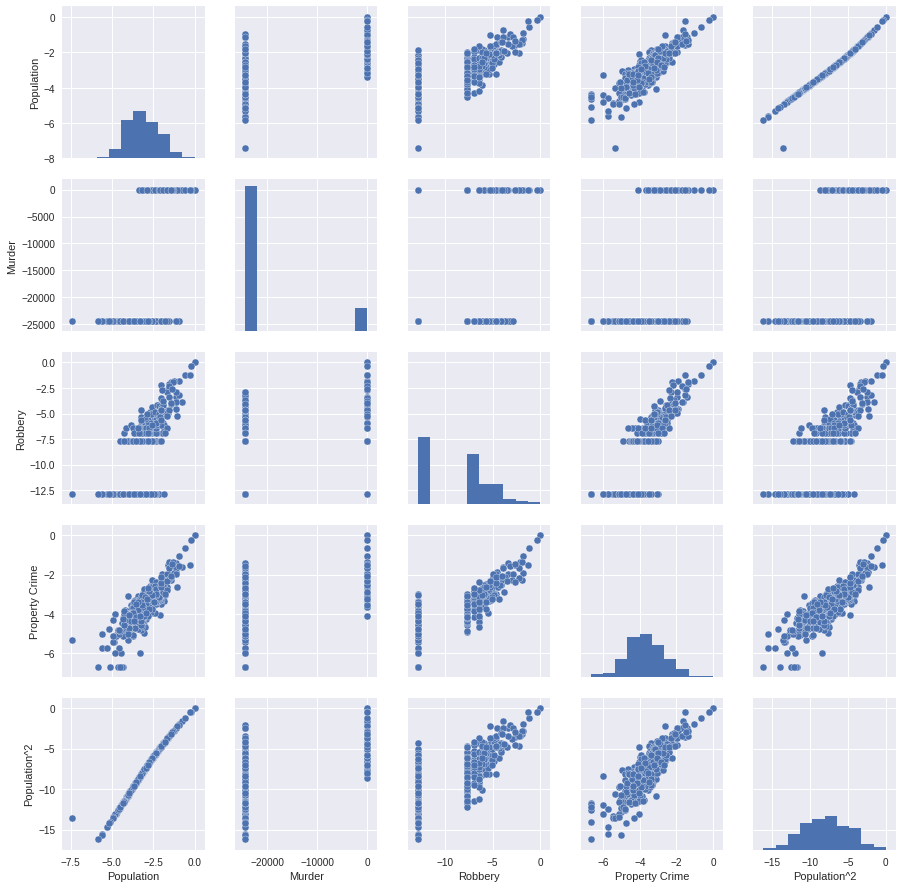

In [20]:
sns.pairplot(crime_model)
plt.show()

In [21]:
# remove significant outliers (more than 3 standard deviations from mean)
crime_model[crime_model.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
crime_model.describe()

,Population,Murder,Robbery,Property Crime,Population^2
count,347.000000,347.000000,347.000000,347.000000,347.000000
mean,-3.118523,-21019.257248,-8.684421,-3.664081,-7.931587
std,1.022517,8424.734169,3.645748,1.054924,2.952673
min,-7.399670,-24389.913659,-12.840614,-6.688023,-16.197664
25%,-3.853872,-24389.913659,-12.840614,-4.316087,-10.143723
50%,-3.152387,-24389.913659,-7.690170,-3.720295,-7.928267
75%,-2.404866,-24389.913659,-5.877492,-3.000632,-5.721844
max,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
crime_model.isnull().sum()

Population        0
Murder            0
Robbery           0
Property Crime    0
Population^2      0
dtype: int64

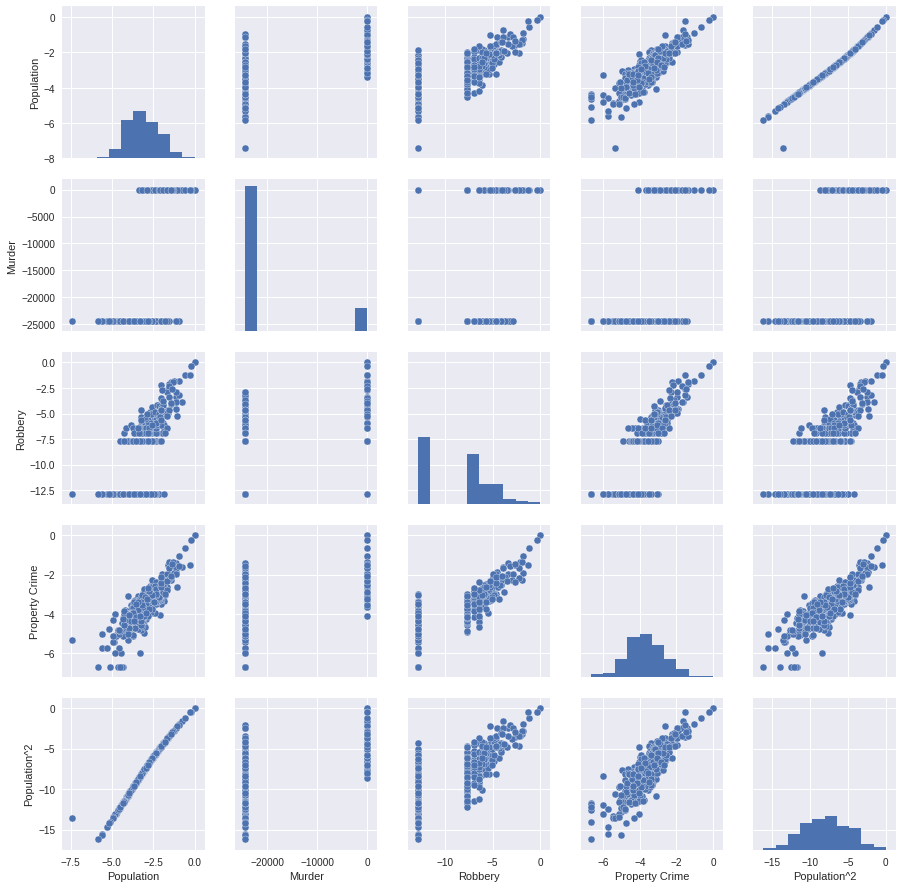

In [23]:
sns.pairplot(crime_model)
plt.show()

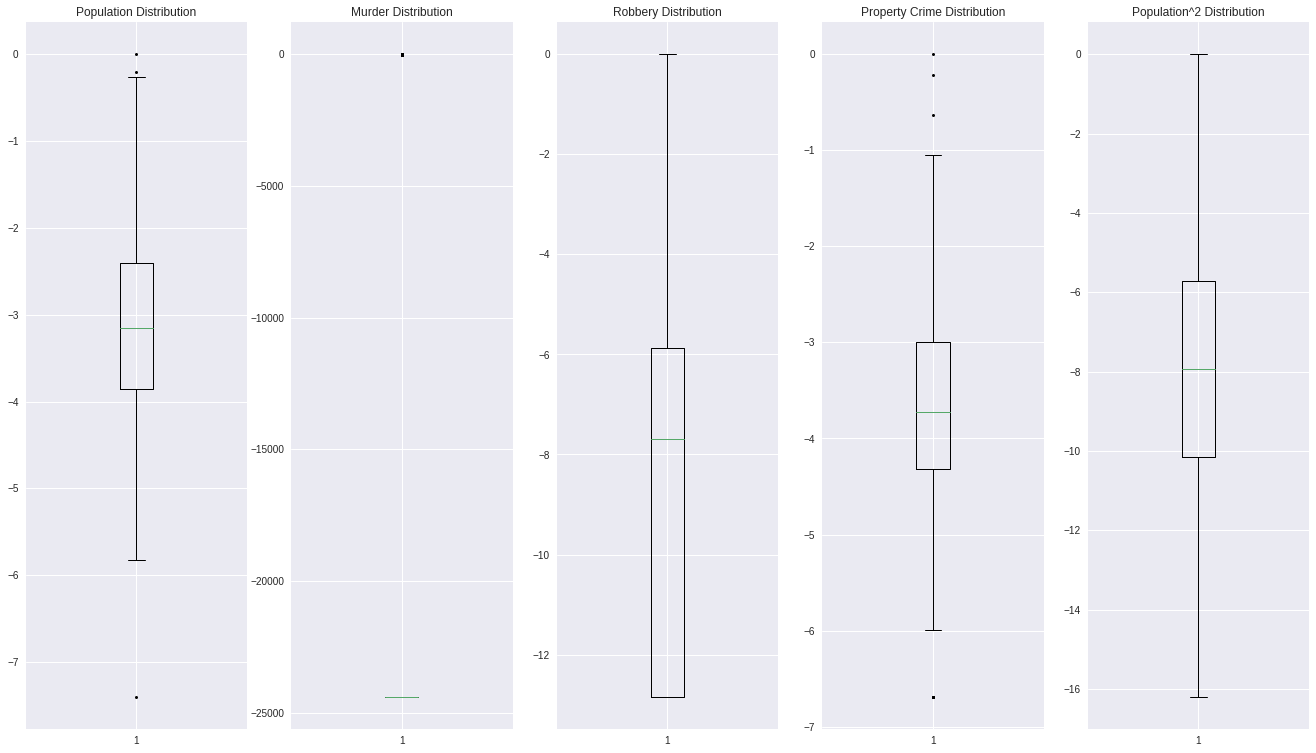

In [24]:
fig,ax = plt.subplots(ncols = 5)
y = 0
for col in col_list:
    ax[y].boxplot(crime_model[col],sym="k.")
    ax[y].set_title(col + " Distribution")
    y+=1
plt.show()

In [25]:
# apply dataframe to linear regression model
crime_regr = linear_model.LinearRegression()
Y = crime_model["Property Crime"]
X = crime_model[["Population","Murder","Robbery"]]
crime_regr.fit(X,Y)

print("Coefficients:\n",crime_regr.coef_)
print("\nIntercept:\n",crime_regr.intercept_)
print("\nR-squared: ")
print(crime_regr.score(X,Y))

Coefficients:
 [5.93589338e-01 5.11214214e-06 1.05927925e-01]

Intercept:
 -0.7855826533726669

R-squared: 
0.8127080663007389


In [26]:
# R-squared value appears extremely high, test for overfitting (holdout groups)
from sklearn.model_selection import cross_val_score
cross_val_score(crime_regr,X,Y,cv=10)

array([0.9109638 , 0.88119189, 0.5522323 , 0.80209189, 0.84066491,
       0.68503108, 0.79046099, 0.81986289, 0.76576178, 0.8301665 ])